# Clustering Conversations (LDA & Hierarchical Clustering)

In [391]:
import gensim
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# My functions are here.
import displayfuncs
import iofuncs
import filterfuncs

from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sys import setrecursionlimit

# https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
# https://tedunderwood.com/2012/11/11/visualizing-topic-models/
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

# Take a look at:
# https://rare-technologies.com/word2vec-tutorial/

sys.setrecursionlimit(10000) # Dendogram failback solution

## Extract conversations from data folders

In [394]:
# Generate the list of file documents to process, from the folders specified
def get_datafiles_list(parent_dir = "/Users/jrenero/OneDrive - Sanitas/DatosChats/"):
    datafolders = ['243861-1476443781']
    #               '243861-1476691434','243861-1476698232','243861-1476698786',
    #               '243861-1476691374','243861-1476691504','243861-1476698458','digital',
    #               '243861-1476691412','243861-1476698142','243861-1476698730','digital_1']
    datafiles = []
    for folder in datafolders:
        datafiles.extend(get_filepaths(parent_dir + folder))
    return(datafiles)

## Generate a separate file for each conversation

In [401]:
def generate_file_per_document(datafiles, output_dir = "./corpus/"):
    # Generate one file per conversation inside each data file.
    i = 0
    l = len(datafiles)
    if l is 0:
        print("No files in datafiles list!")
        return()
    printProgressBar(i, l)
    for file in datafiles:
        extract_conversations(output_dir, file)
        i += 1
        printProgressBar(i, l)

datafiles = get_datafiles_list(parent_dir = "/Users/jrenero/onedrive/DatosChats/")
generate_file_per_document(datafiles)

No files in datafiles list!


()

## Process files and generate documents of words

In [402]:
# Read all the files (documents) and put them into 'texts', filtering out 
# stems/words in the blacklist (badstems.txt)
texts = []
badstems_file = open('./badstems.txt','r')
bad_stems = set(badstems_file.read().splitlines())
badwords_file = open('./badwords.txt','r')
bad_words = set(badwords_file.read().splitlines())

documents = get_filepaths("./reduced_corpus/")
i = 0
l = len(documents)
printProgressBar(i, l)
for file in documents:
    tokens = extract_tokens(file)
    stopped_tokens = remove_stopwords(tokens)
    stems = extract_stems(stopped_tokens)
    ok_words = list(set(stems) - bad_stems)
    if len(ok_words) > 0:
        texts.append(ok_words)
    i += 1
    printProgressBar(i, l)

Progress: |####################| 100.0% Complete


## Run LDA model over the entire corpus.

In [370]:
# Turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# ignore words that appear in less than 50 documents or more than 20% documents
#dictionary.filter_extremes(no_below=50, no_above=0.2)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
n_topics = 10
LDA = gensim.models.ldamulticore.LdaModel
ldamodel = LDA(corpus, num_topics = n_topics, id2word = dictionary, passes=1)
topics = ldamodel.print_topics(num_topics = n_topics, num_words=8)

In [371]:
def doc_stems(filename):
    tokens = extract_stems(remove_stopwords(extract_tokens(filename)))
    return(list(set(tokens) - bad_stems))

def doc_words(filename):
    tokens = remove_stopwords(extract_tokens(filename))
    return(list(set(tokens) - bad_words))

def print_topics(n):
    for i in range(0,n):
        contents = doc_words(documents[i])
        if contents:
            scores = ldamodel[dictionary.doc2bow(contents)]
            max_score = max(scores, key=lambda item:item[1]) # Get the maximum score using a lambda
            print(contents, " -> Topic:", max_score[0])
            print(topics[max_score[0]][1])
            print()

#print_topics(10)

# TF-IDF over the words on each document
We need to consider only those representative words on each document

In [372]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

### TextBlob structure

Create a dictionary of documents, where each word is together with its score in TF-IDF

In [373]:
# A TextBlob structure is needed to perform tf-idf.
bloblist = [tb(" ".join(doc)) for doc in texts]

feature_docs = []
for i, blob in enumerate(bloblist):
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    #print("Top words in document {}".format(i + 1))
    #for word, score in sorted_words[:10]:
    #    print("\tWord: {}, TF-IDF: {}".format(word, round(score, 3)))
    feature_docs.append(sorted_words)

# Show an example for the first doc.
feature_docs[3]

[('borr', 1.2919097607264802),
 ('dental', 0.5836064247124261),
 ('contrat', 0.3189546861988235),
 ('segur', 0.1725755571069285)]

I need to know the distribution of the TF-IDF scores.

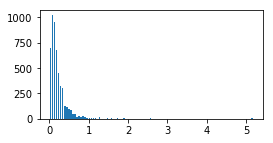

In [374]:
tfs = []
tfs = map((lambda doc: [round(x[1],2) for x in doc]), feature_docs)
flattened = [val for sublist in tfs for val in sublist]
plot_histogram(flattened, num_bins=100)

### Weighting words, and picking up only relevant ones

I need the reverse dictionary where each token is associated with its id. With it, I'll be able to encode the tokens found in the conversations with their codes in the dictionary.

I build the vectors containing the list of codes on each conversation, filtering those with TF-IDF less than the value specified, or with tokens removed from the dictionary because they're no longer relevant.

In [375]:
informative_docs = map((lambda doc: list(filter((lambda word: word[1] > 0.1 and word[1] < 1.0), doc)))
                       , feature_docs)
reverse_dict = dictionary.token2id    

def get_code(x): 
    """
    Obtain the code for each word on this document from the reverse_dictionary. 
    If the word is not found, the code assigned is -1
    """
    y = reverse_dict.get(x[0]) 
    if y != None:
        return(y) 
    else:
        return(-1)

# Build the vectors of IDs per document, removing those docs with less than 2 tokens.
# every unmatched token in the dictionary is fileterd out.
vectors = list(filter(
    (lambda vector: len(vector) > 1)
    ,map((lambda doc: list(filter((lambda token_id: token_id != -1), map(get_code, doc)))), informative_docs)
))

### What is the histogram of vector lengths?
Distribution of number of relevant tokens in the conversations set?

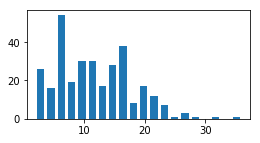

In [376]:
lengths = list(map(len, vectors))
plot_histogram(lengths)

In [377]:
max_length = max(lengths)
print("Max length =", max_length)

def list2array(v, max_length):
    np_array = np.full(max_length, -1)
    l = min(max_length, len(v))
    np_array[:l] = v[:l]
    return (np_array)

sparse_vectors = [list2array(x, max_length) for x in vectors]
X = np.asmatrix(sparse_vectors)
X.shape

Max length = 36


(309, 36)

# Hierarchical Clustering

This part deals with the hierarchical clustering of the words in the dictionary to see how different words tend to group topgether.

https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

This (very very briefly) compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is pretty close:

In [378]:
# generate the linkage matrix
#Z = linkage(X, method='ward'
Z = linkage(X, metric='jaccard')
c, coph_dists = cophenet(Z, pdist(X))
c

0.62882680708735927

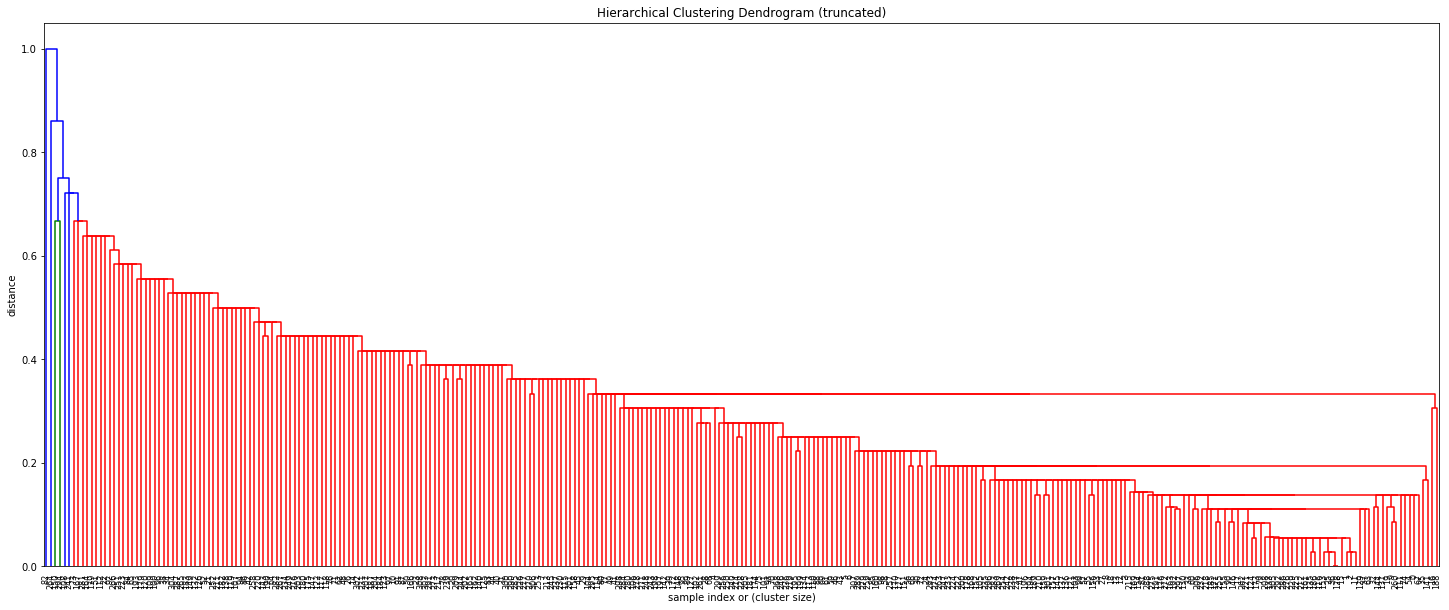

In [379]:
# calculate full dendrogram
max_distance = 0.1

plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    #truncate_mode='lastp',
    #p=500,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    #max_d=max_distance,  # plot a horizontal cut-off line
)
plt.show()

Num of clusters =  281


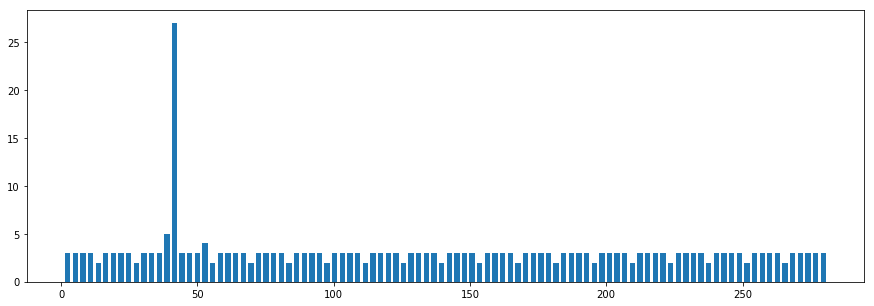

In [386]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_distance, criterion='distance')
print("Num of clusters = ",len(set(clusters)))
plot_histogram(clusters, num_bins=100, fig_width=15, fig_height=5)

In [381]:
clusters

array([ 54,  41,  41,  70, 147, 122, 121, 183,  74,  52, 208,  41,  71,
        72, 217,  41, 165,  45,  73,  53, 199, 247, 270, 205, 108,  41,
       218,  75,  13, 174,  23, 190,  50,  60, 256,  95,  41,  42, 257,
       153, 191, 167, 238, 123, 192, 175, 124,  87, 219, 168,   5, 272,
       248,  76,  56,  31,  21,  77, 113, 125,  37, 126, 220,  43, 235,
       264,  22,  55,  14, 127, 136, 221,  24, 277,  57, 139, 222, 169,
         7,  41, 170,  66, 281, 193, 265, 116, 239, 206, 128, 149,  40,
       207, 269, 137, 240, 150, 258, 209, 114,  78, 259, 138,  16,  79,
       173,  25, 161, 241, 279, 260, 129,  58, 271, 130, 171, 178,  41,
       224, 223, 242, 261,  80, 225, 210,  41, 194, 249, 148,  41,  44,
        61,  59, 250,  41, 131,  41,  81,  82, 243, 273, 195,  96, 154,
         3,  51,  83,  40, 226, 151, 251,   1, 109,  97,  41,  67,  46,
        32,  84, 176,  29, 115,  41, 196,  35, 274, 197,   6, 276,  98,
        68, 111,  39, 152,  41, 140, 227,  62, 110,  99, 262, 22

In [387]:
def cluster_docs(clusters):
    """
    This method builds the list of documents present on each cluster.
    """
    cdocs = dict()
    for cluster in set(clusters):
        docs_in_cluster = [i for i,val in enumerate(clusters) if val==cluster]
        cdocs.setdefault(cluster, []).append(docs_in_cluster)
    return(cdocs)

def extract_words(vector):
    """
    From a list of word IDs, this method extract the words from the dictionary
    """
    words = []
    [ words.append(dictionary.get(value)) if value is not -1 else '' for value in vector.tolist()[0] ]
    return (words)

In [388]:
docs_in_cluster = cluster_docs(clusters)

In [389]:
print(docs_in_cluster.get(41))
seek_docs = docs_in_cluster.get(41)
for d in seek_docs[0]:
    print("CLSTR#",d,"->",sorted(extract_words(X[d])))

[[1, 2, 11, 15, 25, 36, 79, 116, 124, 128, 133, 135, 153, 161, 173, 186, 208, 212, 221, 225, 229, 262, 276, 286, 292, 305]]
CLSTR# 1 -> ['contrat', 'medic', 'segur']
CLSTR# 2 -> ['contrat', 'dental', 'segur']
CLSTR# 11 -> ['contrat', 'dental']
CLSTR# 15 -> ['basic', 'diferent']
CLSTR# 25 -> ['contrat', 'segur']
CLSTR# 36 -> ['preci', 'segur']
CLSTR# 79 -> ['copag', 'diferent', 'primer']
CLSTR# 116 -> ['alta', 'prueb']
CLSTR# 124 -> ['cobertur', 'envi', 'plus']
CLSTR# 128 -> ['preci', 'segur']
CLSTR# 133 -> ['cubr', 'mes', 'segur']
CLSTR# 135 -> ['hij', 'poliz']
CLSTR# 153 -> ['person', 'segur']
CLSTR# 161 -> ['basic', 'carenci', 'period']
CLSTR# 173 -> ['cobertur', 'extranjer', 'multi']
CLSTR# 186 -> ['asegur', 'poliz']
CLSTR# 208 -> ['años', 'dental', 'segur']
CLSTR# 212 -> ['niñ', 'preci']
CLSTR# 221 -> ['juli', 'niñ', 'permanent']
CLSTR# 225 -> ['asegur', 'cubiert']
CLSTR# 229 -> ['cas', 'interes']
CLSTR# 262 -> ['client', 'consult', 'dental']
CLSTR# 276 -> ['cobertur', 'dud']
CLSTR